In [24]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
lemonade = pd.read_csv('https://gist.githubusercontent.com/ryanorsinger/19bc7eccd6279661bd13307026628ace/raw/e4b5d6787015a4782f96cad6d1d62a8bdbac54c7/lemonade.csv')
lemonade.head()

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales
0,1/1/17,Sunday,27.0,2.00,15,0.5,10
1,1/2/17,Monday,28.9,1.33,15,0.5,13
2,1/3/17,Tuesday,34.5,1.33,27,0.5,15
3,1/4/17,Wednesday,44.1,1.05,28,0.5,17
4,1/5/17,Thursday,42.4,1.00,33,0.5,18


### 1. Define a function named get_lower_and_upper_bounds that has two arguments. The first argument is a pandas Series. The second argument is the multiplier, which should have a default argument of 1.5.

In [5]:
for col in lemonade.columns:
    lemonade = lemonade.rename(columns={col: col.lower()})
lemonade.head()

,date,day,temperature,rainfall,flyers,price,sales
0,1/1/17,Sunday,27.0,2.00,15,0.5,10
1,1/2/17,Monday,28.9,1.33,15,0.5,13
2,1/3/17,Tuesday,34.5,1.33,27,0.5,15
3,1/4/17,Wednesday,44.1,1.05,28,0.5,17
4,1/5/17,Thursday,42.4,1.00,33,0.5,18


In [6]:
continuous = ['temperature', 'rainfall', 
              'flyers', 'price', 'sales']

def get_lower_and_upper_bounds(series, multiplier=1.5):
    quantiles = [.25, .5, .75, 1.0]
    
    q = series.quantile(quantiles)
    
    IQR = q.iloc[2] - q.iloc[0]
    upper_bound = IQR* multiplier + q.iloc[2]
    lower_bound = q.iloc[0] - IQR* multiplier
    
    return upper_bound, lower_bound



### Use the IQR Range Rule and the upper and lower bounds to identify the lower outliers of each column of lemonade.csv, using the multiplier of 1.5. Do these lower outliers make sense? Which outliers should be kept?


In [7]:
def lower_outliers_cols(col, m=1.5):
    up_bound, lwr_bound = get_lower_and_upper_bounds(lemonade[col], multiplier=m)
    lwr_lem = lemonade[col][lemonade[col] < lwr_bound].values
    
    return lwr_lem

def upper_outliers_cols(col, m=1.5):
    up_bound, lwr_bound = get_lower_and_upper_bounds(lemonade[col], multiplier=m)
    upper_lem = lemonade[col][lemonade[col] > up_bound].values
    
    return upper_lem
    

In [8]:
lower = []
for col in continuous:
    lower.append({col:lower_outliers_cols(col)})
    
lower = pd.DataFrame(lower)
lower.head()
    

,temperature,rainfall,flyers,price,sales
0,[15.1],NaN,NaN,NaN,NaN
1,NaN,[],NaN,NaN,NaN
2,NaN,NaN,[-38],NaN,NaN
3,NaN,NaN,NaN,[],NaN
4,NaN,NaN,NaN,NaN,[]


get rid of -38 flyers data point, can't have no negative flyers.

### Use the IQR Range Rule and the upper and upper bounds to identify the upper outliers of each column of lemonade.csv, using the multiplier of 1.5. Do these upper outliers make sense? Which outliers should be kept?

In [9]:
upper = []
for col in continuous:
    upper.append({col:upper_outliers_cols(col)})
    
upper = pd.DataFrame(upper)
upper, print(upper.iloc[1, 1])

[2.   1.33 1.33 1.54 1.54 1.54 1.33 1.33 1.67 1.43 1.43 1.54 1.33 1.33
 1.54 1.82 1.43 1.82 1.33 1.43 1.54 1.33 1.43 1.33 1.54 1.43 1.43 2.5 ]


(  temperature                                           rainfall    flyers  \
 0     [212.0]                                                NaN       NaN   
 1         NaN  [2.0, 1.33, 1.33, 1.54, 1.54, 1.54, 1.33, 1.33...       NaN   
 2         NaN                                                NaN  [77, 80]   
 3         NaN                                                NaN       NaN   
 4         NaN                                                NaN       NaN   
 
   price                 sales  
 0   NaN                   NaN  
 1   NaN                   NaN  
 2   NaN                   NaN  
 3    []                   NaN  
 4   NaN  [143, 158, 235, 534]  ,
 None)

Get rid of 212 temp data point, everyone would be dead.

### Using the multiplier of 3, IQR Range Rule, and the lower bounds, identify the outliers below the lower bound in each colum of lemonade.csv. Do these lower outliers make sense? Which outliers should be kept?

In [10]:
lower = []
for col in continuous:
    lower.append(lower_outliers_cols(col, m=3))
    
lower = pd.concat(lower)
lower.head()

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

Shouldn't keep outlier, -38 flyers doesn't make sense

### Using the multiplier of 3, IQR Range Rule, and the upper bounds, identify the outliers above the upper_bound in each colum of lemonade.csv. Do these upper outliers make sense? Which outliers should be kept?

In [11]:
upper = []
for col in continuous:
    upper.append(higher_outliers_cols(col, m = 3))
    
upper = pd.concat(upper)
upper.head()

NameError: name 'higher_outliers_cols' is not defined

Get rid of 212 temp data point, everyone would die

### Identify if any columns in lemonade.csv are normally distributed. For normally distributed columns:

temperature


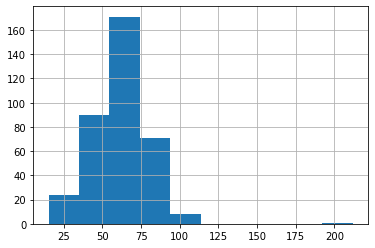

rainfall


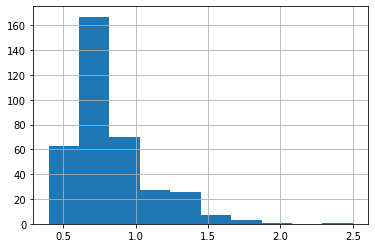

flyers


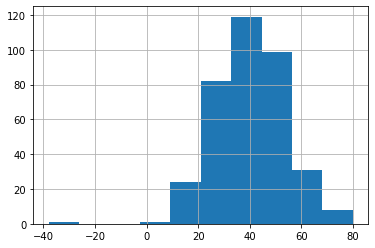

price


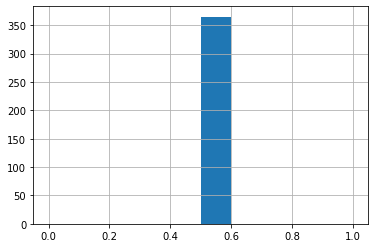

sales


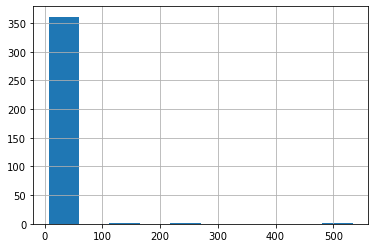

In [12]:
for col in continuous:
    lemonade[col].hist()
    print(col)
    plt.show()

**Use a 2 sigma decision rule to isolate the outliers.**

In [13]:
def two_three_sigma(df):
    continuous = ['temperature', 'rainfall', 'flyers', 'price', 'sales']
    two_sigma = pd.DataFrame()
    three_sigma = pd.DataFrame()
    
    for col in df.columns:
        if col in continuous:
            zscores = pd.Series((df[col] - df[col].mean()) / df[col].std())

            # Finds all of the observations two standard deviations or more.
            two_sigma = pd.concat([two_sigma, df[col][zscores.abs() >= 2]], axis=1)

            # Finds all of the observations three standard deviations or more
            three_sigma = pd.concat([three_sigma, df[col][zscores.abs() >= 3]], axis=1)

    return two_sigma, three_sigma

two, three = two_three_sigma(lemonade)


In [14]:
two

,temperature,rainfall,flyers,price,sales
0,NaN,2.00,NaN,NaN,NaN
5,NaN,1.54,NaN,NaN,NaN
6,NaN,1.54,NaN,NaN,NaN
10,NaN,1.54,NaN,NaN,NaN
15,NaN,1.67,NaN,NaN,NaN
16,NaN,1.43,NaN,NaN,NaN
19,NaN,1.43,NaN,NaN,NaN
23,NaN,1.54,NaN,NaN,NaN
41,212.0,NaN,NaN,NaN,NaN
166,99.3,NaN,77.0,NaN,NaN


In [15]:
three

,temperature,rainfall,flyers,price,sales
0,NaN,2.00,NaN,NaN,NaN
15,NaN,1.67,NaN,NaN,NaN
41,212.0,NaN,NaN,NaN,NaN
181,NaN,NaN,NaN,NaN,143.0
182,NaN,NaN,NaN,NaN,158.0
183,NaN,NaN,NaN,NaN,235.0
184,NaN,NaN,NaN,NaN,534.0
324,NaN,NaN,-38.0,NaN,NaN
338,NaN,1.82,NaN,NaN,NaN
343,NaN,1.82,NaN,NaN,NaN


temp doesn't make sense, sales is large but not impossible, flyers can't be negative

<AxesSubplot:>

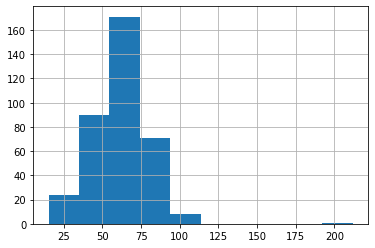

In [16]:
lemonade.temperature.hist()

<AxesSubplot:>

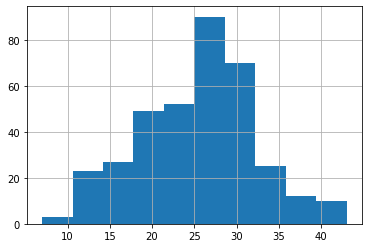

In [19]:
lemonade.sales[lemonade.sales < 100].hist()

<AxesSubplot:>

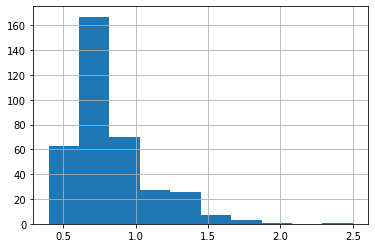

In [20]:
lemonade.rainfall.hist()

<AxesSubplot:>

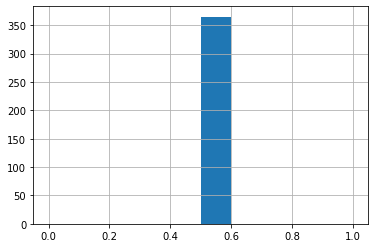

In [21]:
lemonade.price.hist()

In [22]:
lemonade.price.value_counts()

0.5    365
Name: price, dtype: int64

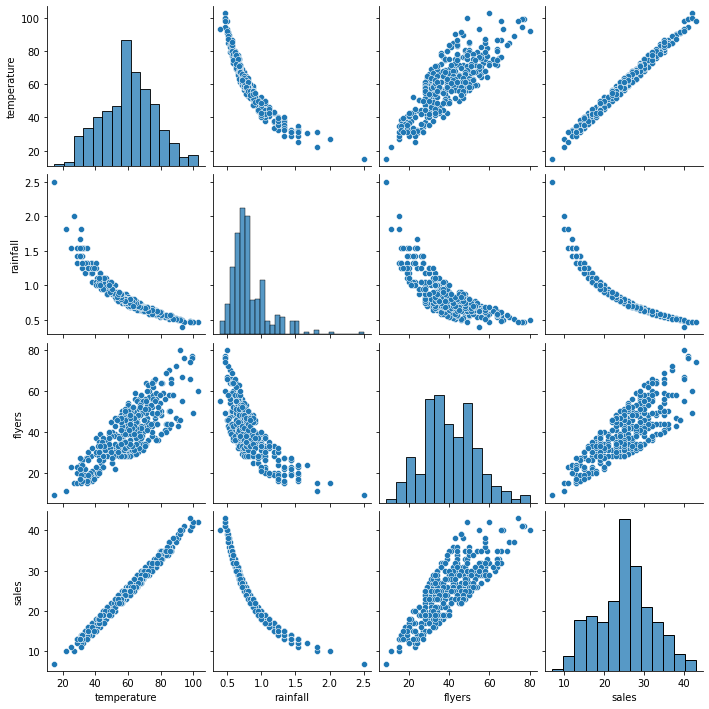

In [29]:
sns.pairplot(lemonade[(lemonade.sales < 100) & (lemonade.flyers >= 0) & (lemonade.temperature <110)].drop(columns='price'))